In [220]:
using Plots, DataFrames, CSV, GLM
using Optim, Distributions, Random
using LinearAlgebra, StatsFuns, ForwardDiff
using LaTeXTabulars

In [140]:
# Load data
df = DataFrame(CSV.File("../data/ps2_ex3.csv"));
rename!(df, :milage => :mileage);

# Number of observations
T = size(df)[1];

# Number of bins for discretization
K = 20;

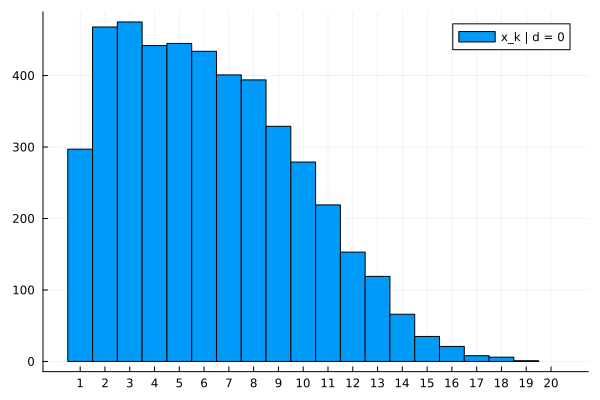

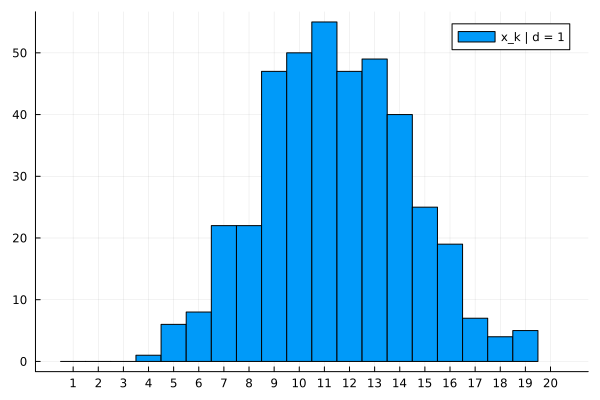

Row,mileage,d,x
,Int64,Int64,Int64
1,23,0,3
2,31,0,3
3,36,0,4
4,46,0,5
5,56,0,6
6,66,0,6
7,75,0,7
8,85,0,8
9,86,0,8


In [143]:
# Infer replacement (d = 1)
df[!,:d] .= 0;
for t = 1:T-1
    df[t,:d] = (df[t+1,:mileage] < df[t,:mileage]);
end

# Discretize mileage into K bins, starting at the minimum value observed
bin_size = (maximum(df.mileage)-minimum(df.mileage)) / K
df[!,:x] = Integer.(fld.((df[!,:mileage] .- minimum(df.mileage)), bin_size)) .+ 1;
df[df.x .=== K+1,:x] .= K

# Define representative mileage for each bin (midpoint)
x_k = zeros(K)
for k = 1:K
    x_k[k] = minimum(df.mileage) + (bin_size * (k-1)) + (bin_size / 2)
end

# Histogram of counts conditional on replacement
display(histogram(vec(df[df.d .=== 0,:].x), 
            bins = 1:1:K, 
            xticks = (1.5:1:K+0.5, 1:1:K), 
            xlimits = (0,K+2),
            labels = "x_k | d = 0"));
display(histogram(vec(df[df.d .=== 1,:].x), 
            bins = 1:1:K, 
            xticks = (1.5:1:K+0.5, 1:1:K), 
            xlimits = (0,K+2),
            labels = "x_k | d = 1"));
            
df

In [144]:
### Construct transition matrix

# Create columns representing indicators for next period bin, y
col_names = []
for k = 1:K
    df[!, "y_$k"] .= 0
    push!(col_names,"y_$k")
end

for t = 1:T-1
    y = df[t+1,:x]
    df[t,"y_$y"] = 1
end

# Calculate transition matrices, Π_d
Π₁ = zeros(20,20)
Π₀ = zeros(20,20)
for x = 1:20
    for y = 1:20
        Π₁[x,y] = mean(df[(df.x .=== x) .& (df.d .=== 1), "y_$y"])
        Π₀[x,y] = mean(df[(df.x .=== x) .& (df.d .=== 0), "y_$y"])
    end
end
replace!(Π₁, NaN .=> 0.0)
replace!(Π₀, NaN .=> 0.0)

# Output matrices
display(Π₁)
display(Π₀)

20×20 Matrix{Float64}:
 0.0       0.0       0.0        0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0       0.0       0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0       0.0       0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.333333  0.666667  0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.5       0.5       0.0        0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.545455  0.409091  0.0454545  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.772727  0.227273  0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.574468  0.404255  0.0212766  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.74      0.26      0.0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.745455  0.254545  0.0        0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.595745  0.382979  0.0212766  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.510204  0.469388  0.0204082  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.7       0.3 

20×20 Matrix{Float64}:
 0.107744  0.747475  0.141414  0.0       …  0.0        0.0       0.0  0.0
 0.0       0.228632  0.666667  0.102564     0.0        0.0       0.0  0.0
 0.0       0.0       0.244211  0.654737     0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.190045     0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0       0.0       0.0          0.0        0.0       0.0  0.0
 0.0       0.0 

In [229]:
# Nested fixed point algorithm 
function nfxp(θ)
    # Starting point
    EV₀ = ones(K)
    
    # Loop parameters
    tol = 1e-12
    err = 1000
    n = 0
    # Fixed point iterations
    while (err > tol)
        n += 1
        f = log.(exp(-θ[3] + β*EV₀[1]) .+ exp.(-θ[1].*x_k - θ[2].*(x_k ./ 100).^2 + β.*EV₀))
        EV₁ = Π₀ * f
        err = maximum(abs.(EV₁ - EV₀))
        EV₀ = EV₁
    end

    return EV₀
end

# Calculate conditional choice probability
function ccp(θ,EV)
    p = 1 ./ (1 .+ exp.(-θ[1].*x_k - θ[2].*(x_k ./ 100).^2 .+ θ[3] .+ β.*(EV .- EV[1])))
    
    return p
end

# Evaluate likelihood
function likelihood(θ)
    # Compute value
    EV = nfxp(θ)
    
    # Compute conditional choice probabilities across states
    c = ccp(θ,EV)
    
    # Map conditional choice probabilities to data
    p = zeros(T)
    for t = 1:T
        p[t] = c[df[t,:x]]
    end
    d = vec(df[!,:d])

    # Return negative log-likelihood to minimize
    ll = sum(log.(p.^d .* (1 .- p).^(1 .- d)))
    
    return -ll
end

likelihood (generic function with 2 methods)

In [230]:
# Solve model
β = 0.999

params0 = [0.01, 0.01, 0.01]

o = optimize(likelihood, params0, NelderMead())

 * Status: success

 * Candidate solution
    Final objective value:     1.402158e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   50  (vs limit Inf)
    Iterations:    187
    f(x) calls:    360


In [237]:
# Results
o.minimizer

3-element Vector{Float64}:
 -0.020780548309629505
  1.1702963181096888
 -0.5382035675818557